In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [33]:
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
rank_to_index = {rank: i for i, rank in enumerate(ranks)}
rank_len = len(ranks)

#Helper functions for data processing
def card_to_vec(card):
    raw_rank = card[:-1]
    one_hot_vector = [0] * rank_len
    one_hot_vector[rank_to_index[raw_rank]] = 1
    return one_hot_vector

def hand_to_list(hand):
    '''Takes hand like KH-AC and outputs list of card numbers'''
    hand_list_1 = hand.split("-")
    hand_list_2 = [card_to_vec(card) for card in hand_list_1]
    return hand_list_2

result_mapping = {
    'hit' : 0,
    'stand' : 1,
    'double down' : 2
}

batch_size = 32

# Defining Dataset Class
class Blackjack_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [34]:
# Data Processing
hit_stand_dd_df = pd.read_csv('CSVs/hit_stand_dd.csv')

In [35]:
hsd_train_df, hsd_test_df = train_test_split(hit_stand_dd_df, test_size = 0.2)

def clean_up(dataframe_raw):
    # Cleaned hit_stand_dd
    max_len = 7
    dataframe_raw['dealer_upcard'] = dataframe_raw['dealer_upcard'].apply(card_to_vec)
    dataframe_raw['player_hand'] = dataframe_raw['player_hand'].apply(hand_to_list)
    dataframe_raw['result'] = dataframe_raw['result'].map(result_mapping)
    
    zero_vector = [0] * rank_len
    padded_hands = []
    for hand in dataframe_raw['player_hand']:
        if len(hand) < max_len:
            padded_hand = hand + [zero_vector] * (max_len - len(hand))
        else: 
            padded_hand = hand[:max_len]
        padded_hands.append(padded_hand)
    dataframe_raw['player_hand'] = padded_hands

    # Flattening
    dataframe_raw['player_hand'] = dataframe_raw['player_hand'].apply(lambda hand: [item for card_vec in hand for item in card_vec])
    
    # Turning into tensor matrices
    # hit_stand_dd
    x1 = torch.tensor(dataframe_raw['player_hand'].to_list(), dtype=torch.float32)
    x2 = torch.tensor(dataframe_raw['dealer_upcard'].to_list(), dtype=torch.float32)
    x3 = torch.tensor(dataframe_raw['can_double'].values, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(dataframe_raw['result'].values, dtype=torch.long)

    X = torch.cat([x1,x2,x3], dim=1)

    return Blackjack_Dataset(X,y)

hsd_train_dataset = clean_up(hsd_train_df)
hsd_test_dataset = clean_up(hsd_test_df)

hsd_train_dataloader = DataLoader(hsd_train_dataset, batch_size=batch_size, shuffle=True)
hsd_test_dataloader = DataLoader(hsd_test_dataset, batch_size=batch_size, shuffle=True)

In [36]:
for X, y in hsd_train_dataloader:
    print(X.shape)  # input batch shape: (batch_size, input_features)
    print(y.shape)  # target batch shape: (batch_size,) or (batch_size, something)
    break  # just one batch

torch.Size([32, 105])
torch.Size([32])


In [120]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Printing Training Update on every 100th batch
        if (batch + 1) % 100 == 0: 
            loss = loss.item()
            current = batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

test_losses = []
test_accs = []

def test_loop(dataloader, model, loss_fn):
    #Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    #Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for X, y in dataloader: 
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    test_accs.append(100*correct)
    test_losses.append(test_loss)

In [ ]:
class hsd_NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(105, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

hsd_model = hsd_NeuralNetwork()

learning_rate = 0.02
epochs = 80

loss_fn = nn.CrossEntropyLoss()
hsd_optimizer = torch.optim.SGD(hsd_model.parameters(), lr=learning_rate)

In [122]:
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------")
    train_loop(hsd_train_dataloader, hsd_model, loss_fn, hsd_optimizer)
    test_loop(hsd_test_dataloader, hsd_model, loss_fn)
print("Done!")

Epoch 1
---------------------------
loss: 0.927867  [ 3200/209452]
loss: 0.929596  [ 6400/209452]
loss: 0.895415  [ 9600/209452]
loss: 0.883648  [12800/209452]
loss: 0.875630  [16000/209452]
loss: 0.963801  [19200/209452]
loss: 0.860956  [22400/209452]
loss: 1.018355  [25600/209452]
loss: 1.069070  [28800/209452]
loss: 0.878399  [32000/209452]
loss: 0.757014  [35200/209452]
loss: 0.668822  [38400/209452]
loss: 0.687241  [41600/209452]
loss: 0.714075  [44800/209452]
loss: 0.518746  [48000/209452]
loss: 0.617971  [51200/209452]
loss: 0.455782  [54400/209452]
loss: 0.368785  [57600/209452]
loss: 0.539719  [60800/209452]
loss: 0.624676  [64000/209452]
loss: 0.427964  [67200/209452]
loss: 0.358485  [70400/209452]
loss: 0.354833  [73600/209452]
loss: 0.553433  [76800/209452]
loss: 0.232051  [80000/209452]
loss: 0.477006  [83200/209452]
loss: 0.510763  [86400/209452]
loss: 0.584278  [89600/209452]
loss: 0.350896  [92800/209452]
loss: 0.347620  [96000/209452]
loss: 0.331902  [99200/209452]
los

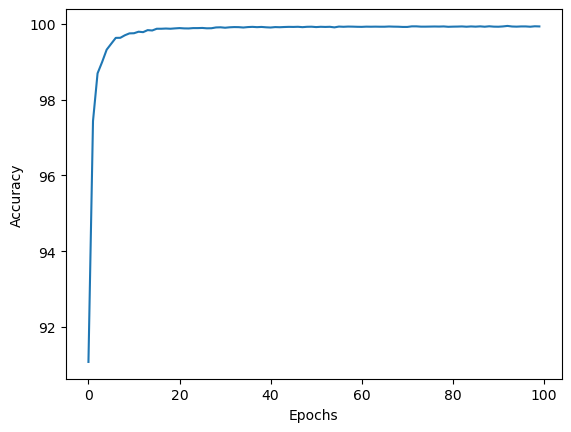

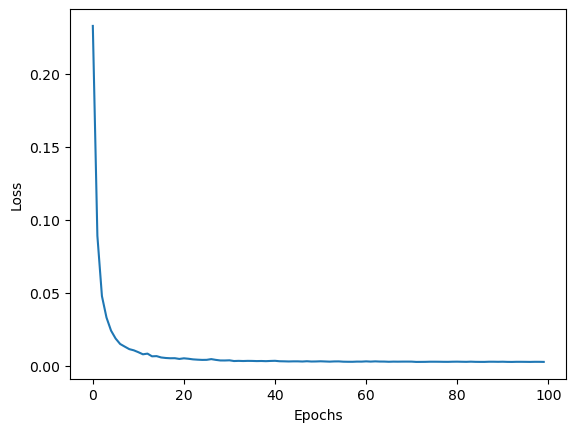

In [123]:
plt.plot(test_accs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(test_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

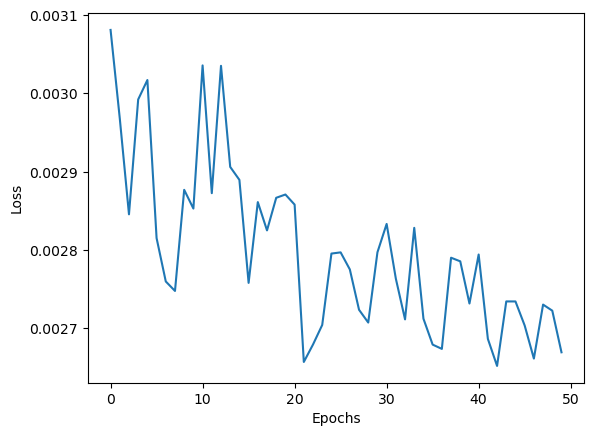

In [124]:
plt.plot(test_losses[50:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

*Best Performance*

dataset size = 261,816
train/test split = 80/20

learning rate = 0.01
epochs = 30
batch_size = 32

Accuracy = 100.0% (first at epoch 25 but bounces around a bit)
Loss = 0.001933

The saved model achieved 0.002006 with parameters .02, 80.
Trying 100 epochs resulted in worse performance. 

In [118]:
model = hsd_NeuralNetwork()
torch.save(model, "hsd_imit_nn.pt")